# GTZAN_2_LogisticRegression
---

In [1]:
import numpy as np
import pandas as pd
import librosa
import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, plot_confusion_matrix, plot_precision_recall_curve, plot_roc_curve, precision_score, recall_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV, RidgeClassifierCV, RidgeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

import scikitplot as skplt
from matplotlib.colors import ListedColormap
cmap = ListedColormap(sns.color_palette("husl", 3))

# Read in file

In [2]:
# read in file
filepath = '../gtzan/own_csv/df_noduplicates.csv'
df_3 = pd.read_csv(filepath, index_col=0)

# drop columns: 'filename', 'length' 
df_3.drop(columns=['filename', 'length'], inplace=True)

print(df_3.shape)
df_3.head(3)

(9847, 58)


,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,1.080790e+06,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,6.722448e+05,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,7.907127e+05,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues


# Set target, predictors, standardization

In [3]:
# set target and features
X = df_3.copy()
y = X.pop('label')

# train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=1)

# standardscaler
scaler = StandardScaler()
X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns, index=X_train.index)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X.columns, index=X_test.index)

# Baseline
y_test.value_counts(normalize=True)

jazz         0.101523
blues        0.101523
classical    0.101523
country      0.101015
rock         0.100508
disco        0.100508
reggae       0.100000
hiphop       0.099492
pop          0.099492
metal        0.094416
Name: label, dtype: float64

# LogReg (original features)

LogReg (no regularisation)

Train score:	 0.7284499174812746
CV mean:	 0.7064845701393925
Test score:	 0.7121827411167513


array([[585,   6,  36,  14,  14,  46,  51,   0,  28,  20],
       [  4, 762,   9,   3,   0,  14,   0,   0,   1,   5],
       [ 69,   5, 507,  32,   7,  46,   6,  20,  27,  79],
       [ 21,   5,  22, 537,  39,   5,  21,  51,  29,  61],
       [ 35,   4,  20,  43, 503,   1,  33,  36, 101,   6],
       [ 43,  50,  40,   5,   2, 640,   0,   4,  10,   6],
       [ 18,   1,   3,  17,   6,   5, 658,   0,   8,  28],
       [  0,   3,  29,  33,  19,  11,   0, 646,  24,  19],
       [ 29,   2,  46,  29,  72,  16,   5,  37, 524,  30],
       [ 73,   4,  66, 100,  22,  35,  40,  25,  49, 376]])

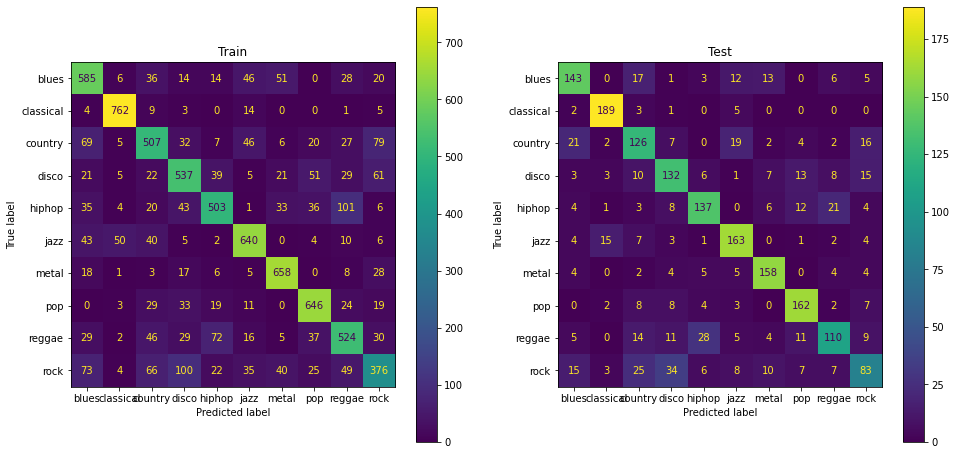

In [5]:
# fit model
model = LogisticRegression(max_iter=10000, multi_class='ovr', solver='liblinear')
model.fit(X_train, y_train)

train_score = model.score(X_train, y_train)
cv_mean = cross_val_score(model, X_train, y_train, cv=5).mean()
test_score = model.score(X_test, y_test)

print('LogReg (no regularisation)')
print()
print('Train score:\t', model.score(X_train, y_train))
print('CV mean:\t', cross_val_score(model, X_train, y_train, cv=5).mean())
print('Test score:\t', model.score(X_test, y_test))

# confusion matrix
pred_train = model.predict(X_train)
pred_test = model.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,8))
plot_confusion_matrix(model, X_train, y_train, ax=ax[0])
plot_confusion_matrix(model, X_test, y_test, ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [6]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     0.6670    0.7312    0.6977       800
   classical     0.9050    0.9549    0.9293       798
     country     0.6517    0.6353    0.6434       798
       disco     0.6605    0.6789    0.6696       791
      hiphop     0.7354    0.6432    0.6862       782
        jazz     0.7814    0.8000    0.7906       800
       metal     0.8084    0.8844    0.8447       744
         pop     0.7888    0.8240    0.8060       784
      reggae     0.6542    0.6633    0.6587       790
        rock     0.5968    0.4759    0.5296       790

    accuracy                         0.7284      7877
   macro avg     0.7249    0.7291    0.7256      7877
weighted avg     0.7245    0.7284    0.7250      7877


Classification report: test set

              precision    recall  f1-score   support

       blues     0.7114    0.7150    0.7132       200
   classical     0.8791    0.9450    0.9108       200
     coun

# LogRegCV (original features)

In [19]:
model_cv = LogisticRegressionCV(multi_class='ovr', max_iter=1000, cv=5, verbose=0)
model_cv.fit(X_train, y_train)

print('LogRegCV (original features)')
print()
print('Train score:\t', model_cv.score(X_train, y_train))
print('CV mean:\t', cross_val_score(model_cv, X_train, y_train, cv=5).mean())
print('Test score:\t', model_cv.score(X_test, y_test))

LogRegCV (original features)

Train score:	 0.7312428589564555
CV mean:	 0.7087690758198372
Test score:	 0.7091370558375635


In [12]:
model_l2 = LogisticRegressionCV(penalty='l2', Cs=np.logspace(-4,4,10), 
                                cv=5, multi_class='ovr', class_weight='balanced', 
                                max_iter=1000, n_jobs=2, verbose=1, random_state=1, refit=False)

model_l2.fit(X_train, y_train)

print('LogReg Ridge (original features)')
print()
print('Train score:\t', model_l2.score(X_train, y_train))
print('CV mean:\t', cross_val_score(model_l2, X_train, y_train, cv=5).mean())
print('Test score:\t', model_l2.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.7s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   12.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.


LogReg Ridge (original features)

Train score:	 0.7285768693665101


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.4s


CV mean:	 0.7083889291757312
Test score:	 0.7111675126903553


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   13.1s finished


In [10]:
print('Train score:\t', lr_ridge.score(X_train, y_train))
print('CV mean:\t', cross_val_score(lr_ridge, X_train, y_train, cv=5).mean())
print('Test score:\t', lr_ridge.score(X_test, y_test))

Train score:	 0.730354195759807


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.5s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.6s
[Parallel(n_jobs=2)]: Done  50 out of  5

CV mean:	 0.7091496253323665
Test score:	 0.7101522842639594


In [27]:
model_l1 = LogisticRegressionCV(penalty='l1', Cs=np.logspace(-4,4,10), solver='saga', 
                                cv=5, multi_class='ovr', class_weight='balanced', 
                                max_iter=1000, n_jobs=2, verbose=1, random_state=1)

model_l1.fit(X_train, y_train)

print('LogReg Lasso (original features)')
print()
print('Train score:\t', model_l1.score(X_train, y_train))
print('CV mean:\t', cross_val_score(model_l1, X_train, y_train, cv=5).mean())
print('Test score:\t', model_l1.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.


convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 30 epochs took 1 seconds
convergence after 31 epochs took 1 seconds
convergence after 406 epochs took 1 seconds
convergence after 608 epochs took 2 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 365 epochs took 1 seconds
convergence after 12 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 31 epochs took 0 seconds
convergence after 286 epochs took 1 seconds
convergence after 10 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 32 epochs took 0 seconds
convergence after 466 epochs took 2 seconds
convergence after 408 epochs took 2 seconds
max_iter reached after 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 338 epochs took 1 seconds
convergence after 11 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 330 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 29 epochs took 0 seconds
convergence after 124 epochs took 1 seconds
convergence after 265 epochs took 1 seconds
convergence after 431 epochs took 2 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 404 epochs took 2 seconds
convergence after 11 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 56 epochs took 0 seconds
convergence after 273 epochs took 1 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 130 epochs took 0 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 505 epochs took 2 seconds
max_iter reached after 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 6 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 53 epochs took 0 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 584 epochs took 2 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 172 epochs took 0 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 409 epochs took 2 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 32 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 353 epochs took 2 seconds
max_iter reached after 6 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 738 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 318 epochs took 1 seconds
convergence after 56 epochs took 0 seconds
convergence after 9 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 40 epochs took 0 seconds
convergence after 124 epochs took 0 seconds
max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 40 epochs took 0 seconds
convergence after 269 epochs took 1 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 735 epochs took 4 seconds
convergence after 996 epochs took 5 seconds
convergence after 283 epochs took 1 seconds
convergence after 50 epochs took 0 seconds
convergence after 5 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 52 epochs took 1 seconds
convergence after 323 epochs took 1 seconds
convergence after 714 epochs took 4 seconds
convergence after 286 epochs took 2 seconds
convergence after 50 epochs took 0 seconds
convergence after 6 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 38 epochs took 0 seconds
max_iter reached after 5 seconds
convergence after 363 epochs took 2 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 725 epochs took 3 seconds
convergence after 991 epochs took 4 seconds
convergence after 286 epochs took 1 seconds
convergence after 51 epochs took 1 seconds
convergence after 8 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 43 epochs took 0 seconds
convergence after 137 epochs took 0 seconds
convergence after 725 epochs took 4 seconds
convergence after 238 epochs took 1 seconds
convergence after 54 epochs took 0 seconds
convergence after 7 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 43 epochs took 0 seconds
convergence after 120 epochs took 1 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 963 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 316 epochs took 2 seconds
convergence after 11 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 43 epochs took 0 seconds
convergence after 142 epochs took 1 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 235 epochs took 1 seconds
convergence after 11 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 43 epochs took 0 seconds
convergence after 126 epochs took 0 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 864 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 238 epochs took 1 seconds
convergence after 8 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 41 epochs took 0 seconds
convergence after 154 epochs took 1 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 149 epochs took 0 seconds
convergence after 13 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 27 epochs took 0 seconds
convergence after 125 epochs took 0 seconds
convergence after 301 epochs took 2 seconds
convergence after 900 epochs took 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 195 epochs took 1 seconds
convergence after 46 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
convergence after 113 epochs took 1 seconds
convergence after 484 epochs took 2 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 247 epochs took 1 seconds
convergence after 13 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
convergence after 109 epochs took 1 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 374 epochs took 2 seconds
convergence after 10 epochs took 0 seconds
convergence after 8 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 23 epochs took 0 seconds
convergence after 121 epochs took 0 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 623 epochs took 3 seconds
convergence after 624 epochs took 3 seconds
convergence after 540 epochs took 2 seconds
convergence after 728 epochs took 3 seconds
convergence after 367 epochs took 2 seconds
convergence after 81 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 22 epochs took 1 seconds
convergence after 196 epochs took 1 seconds
convergence after 23 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 120 epochs took 0 seconds
convergence after 34 epochs took 0 seconds
convergence after 295 epochs took 1 seconds
convergence after 804 epochs took 4 seconds
convergence after 886 epochs took 4 seconds
convergence after 831 epochs took 3 seconds
convergence after 237 epochs took 2 seconds
conve

/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 318 epochs took 2 seconds
convergence after 572 epochs took 3 seconds
convergence after 76 epochs took 0 seconds
convergence after 9 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 36 epochs took 1 seconds
convergence after 301 epochs took 2 seconds
convergence after 970 epochs took 6 seconds
convergence after 921 epochs took 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 618 epochs took 3 seconds
convergence after 73 epochs took 1 seconds
convergence after 9 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 34 epochs took 0 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 294 epochs took 1 seconds
convergence after 658 epochs took 3 seconds
convergence after 84 epochs took 1 seconds
convergence after 12 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 30 epochs took 0 seconds
convergence after 729 epochs took 4 seconds
convergence after 293 epochs took 1 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 651 epochs took 3 seconds
convergence after 81 epochs took 1 seconds
convergence after 12 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 49 epochs took 0 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 399 epochs took 2 seconds
convergence after 895 epochs took 4 seconds
convergence after 89 epochs took 1 seconds
convergence after 12 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 52 epochs took 0 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 380 epochs took 2 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 921 epochs took 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 562 epochs took 2 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 47 epochs took 0 seconds
convergence after 278 epochs took 2 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 786 epochs took 3 seconds
max_iter reached after 4 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 45 epochs took 1 seconds
convergence after 294 epochs took 1 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 911 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 44 epochs took 0 seconds
convergence after 492 epochs took 2 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 52 epochs took 0 seconds
convergence after 293 epochs took 1 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 709 epochs took 3 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 377 epochs took 2 seconds
convergence after 35 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 50 epochs took 0 seconds
convergence after 333 epochs took 1 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 182 epochs took 1 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 54 epochs took 0 seconds
convergence after 315 epochs took 1 seconds
convergence after 937 epochs took 4 seconds
convergence after 612 epochs took 3 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 538 epochs took 3 seconds
convergence after 309 epochs took 1 seconds
convergence after 33 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 33 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 5 epochs took 0 seconds
convergence after 49 epochs took 0 seconds
convergence after 49 epochs took 1 seconds
convergence after 316 epochs took 2 seconds
convergence after 395 epochs took 1 seconds
convergence after 593 epochs took 3 seconds
convergence after 858 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 672 epochs took 3 seconds
convergence after 168 epochs took 1 seconds
convergence after 26 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 55 epochs took 0 seconds
convergence after 794 epochs took 4 seconds
convergence after 90 epochs took 0 seconds
convergence after 183 epochs took 1 seconds
convergence after 26 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 53 epochs took 0 seconds
convergence after 84 epochs took 1 seconds
convergence after 368 epochs took 2 seconds
convergence after 905 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 979 epochs took 4 seconds
convergence after 224 epochs took 1 seconds
convergence after 31 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 42 epochs took 0 seconds
convergence after 111 epochs took 1 seconds
convergence after 770 epochs took 4 seconds
convergence after 177 epochs took 0 seconds
convergence after 24 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 54 epochs took 0 seconds
convergence after 95 epochs took 0 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 739 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 796 epochs took 3 seconds
convergence after 126 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 51 epochs took 0 seconds
convergence after 87 epochs took 0 seconds
convergence after 991 epochs took 4 seconds
convergence after 246 epochs took 1 seconds
convergence after 34 epochs took 0 seconds
convergence after 5 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 27 epochs took 0 seconds
convergence after 607 epochs took 3 seconds
convergence after 156 epochs took 1 seconds
convergence after 524 epochs took 2 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 796 epochs took 3 seconds
convergence after 203 epochs took 1 seconds
convergence after 26 epochs took 0 seconds
convergence after 4 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 3 epochs took 0 seconds
convergence after 23 epochs took 1 seconds
convergence after 159 epochs took 0 seconds
convergence after 600 epochs took 2 seconds
convergence after 113 epochs took 1 seconds
convergence after 17 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds


[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  6.5min


convergence after 25 epochs took 0 seconds
convergence after 157 epochs took 1 seconds
convergence after 699 epochs took 3 seconds
convergence after 956 epochs took 4 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 565 epochs took 3 seconds
max_iter reached after 4 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 115 epochs took 0 seconds
convergence after 17 epochs took 1 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 27 epochs took 0 seconds
convergence after 165 epochs took 0 seconds
convergence after 541 epochs took 3 seconds
convergence after 103 epochs took 0 seconds
convergence after 14 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 1 epochs took 0 seconds
convergence after 25 epochs took 0 seconds
convergence after 153 epochs took 1 seconds
convergence after 611 epochs took 3 seconds
convergence after 899 epochs took 4 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 517 epochs took 2 seconds
convergence after 98 epochs took 1 seconds
convergence after 14 epochs took 0 seconds
convergence after 2 epochs took 0 seconds
max_iter reached after 5 seconds


/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


convergence after 580 epochs took 2 seconds
convergence after 114 epochs took 1 seconds
convergence after 16 epochs took 0 seconds
convergence after 2 epochs took 0 seconds


[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  6.9min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "


LogReg Lasso (original features)

Train score:	 0.730862003300749


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.9min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  5.2min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.4min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  5.7min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The ma

CV mean:	 0.7083879622915157
Test score:	 0.7152284263959391


In [29]:
# pickle logreg_cv
filename = 'log_cv.pkl'
pickle.dump(model_cv, open(filename, 'wb'))

# pickle logreg_ridge
filename = 'log_ridge.pkl'
pickle.dump(model_l2, open(filename, 'wb'))

# pickle logreg_lasso
filename = 'log_lasso.pkl'
pickle.dump(model_l1, open(filename, 'wb'))

In [5]:
# read in models
filename = 'log_ridge.pkl'
lr_ridge = pickle.load(open(filename, 'rb'))

filename = 'log_lasso.pkl'
lr_lasso = pickle.load(open(filename, 'rb'))

In [10]:
print('cv mean:\t', cross_val_score(lr_ridge, X_train, y_train, cv=5).mean())
print('cv scores:\t', cross_val_score(lr_ridge, X_train, y_train, cv=5))
print('cv var:\t', cross_val_score(lr_ridge, X_train, y_train, cv=5).var())
print()
print('train score:\t', lr_ridge.score(X_train, y_train))
print('test score:\t', lr_ridge.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   13.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   13.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   12.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   12.9s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  50 out of  5

cv mean:	 0.7091496253323665


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.5s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.6s
[Parallel(n_jobs=2)]: Done  50 out of  5

cv scores:	 [0.72715736 0.71954315 0.69650794 0.70285714 0.69968254]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.3s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   11.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   11.4s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   12.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.0s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:   10.1s
[Parallel(n_jobs=2)]: Done  50 out of  5

cv var:	 0.00014426743244062734

train score:	 0.730354195759807
test score:	 0.7101522842639594


array([[586,   4,  37,  15,  14,  46,  46,   0,  27,  25],
       [  4, 763,   9,   4,   0,  13,   0,   0,   0,   5],
       [ 66,   3, 514,  35,   7,  46,   6,  20,  29,  72],
       [ 17,   3,  22, 556,  38,   7,  21,  46,  29,  52],
       [ 33,   3,  20,  43, 504,   0,  34,  42,  96,   7],
       [ 41,  47,  38,   7,   2, 647,   0,   3,   8,   7],
       [ 16,   2,   3,  16,   8,   7, 664,   0,   6,  22],
       [  0,   2,  37,  34,  21,  11,   0, 639,  25,  15],
       [ 30,   1,  47,  28,  72,  16,   6,  38, 522,  30],
       [ 76,   5,  70, 106,  26,  31,  45,  24,  49, 358]])

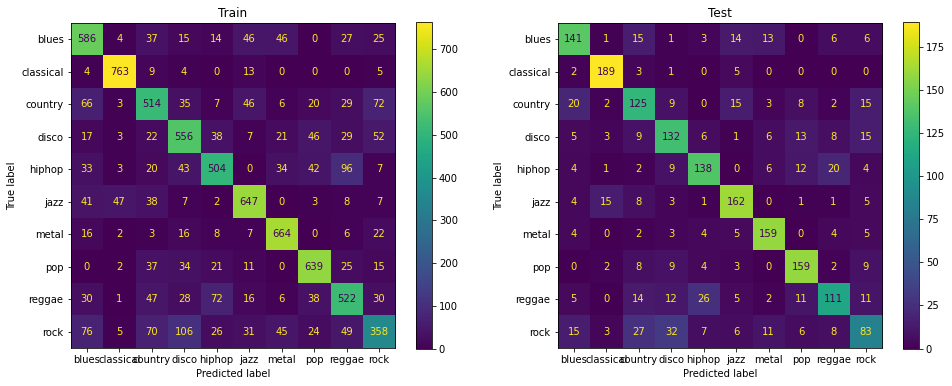

In [7]:
# confusion matrix
pred_train = lr_ridge.predict(X_train)
pred_test = lr_ridge.predict(X_test)
conf_matrix = confusion_matrix(y_train, pred_train)
display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(lr_ridge, X_train, y_train, ax=ax[0])
plot_confusion_matrix(lr_ridge, X_test, y_test, ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [8]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     0.6743    0.7325    0.7022       800
   classical     0.9160    0.9561    0.9356       798
     country     0.6449    0.6441    0.6445       798
       disco     0.6588    0.7029    0.6801       791
      hiphop     0.7283    0.6445    0.6839       782
        jazz     0.7852    0.8087    0.7968       800
       metal     0.8078    0.8925    0.8480       744
         pop     0.7869    0.8151    0.8008       784
      reggae     0.6599    0.6608    0.6603       790
        rock     0.6037    0.4532    0.5177       790

    accuracy                         0.7304      7877
   macro avg     0.7266    0.7310    0.7270      7877
weighted avg     0.7262    0.7304    0.7265      7877


Classification report: test set

              precision    recall  f1-score   support

       blues     0.7050    0.7050    0.7050       200
   classical     0.8750    0.9450    0.9087       200
     coun

In [16]:
print('cv mean:\t', cross_val_score(lr_lasso, X_train, y_train, cv=5).mean())
print('cv scores:\t', cross_val_score(lr_lasso, X_train, y_train, cv=5))
print('cv var:\t', cross_val_score(lr_lasso, X_train, y_train, cv=5).var())
print()
print('train score:\t', lr_lasso.score(X_train, y_train))
print('test score:\t', lr_lasso.score(X_test, y_test))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  4.5min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  4.8min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  5.5min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The ma

cv mean:	 0.7083879622915157


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.7min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  6.0min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.0min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  5.4min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The ma

cv scores:	 [0.72335025 0.7214467  0.69587302 0.69904762 0.70222222]


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed: 54.5min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed: 54.8min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn("The max_iter was reached which means "
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:  5.1min
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:  5.5min finished
/Users/johakaishi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_sag.py:329: ConvergenceWarning: The ma

cv var:	 0.00013525661151358672

train score:	 0.730862003300749
test score:	 0.7152284263959391


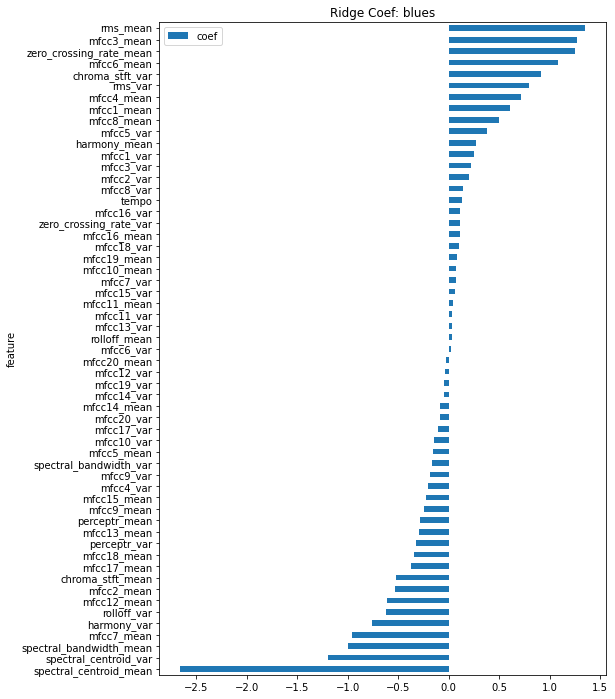

In [14]:
# model coefficients for blues class
pd.DataFrame(list(zip(X.columns, lr_ridge.coef_[0])), 
             columns=['feature', 'coef'])\
    .sort_values(by='coef') \
    .plot(kind='barh', x='feature', y='coef', figsize=(8, 12))
plt.title(f'Ridge Coef: {lr_ridge.classes_[0]}')
plt.show()

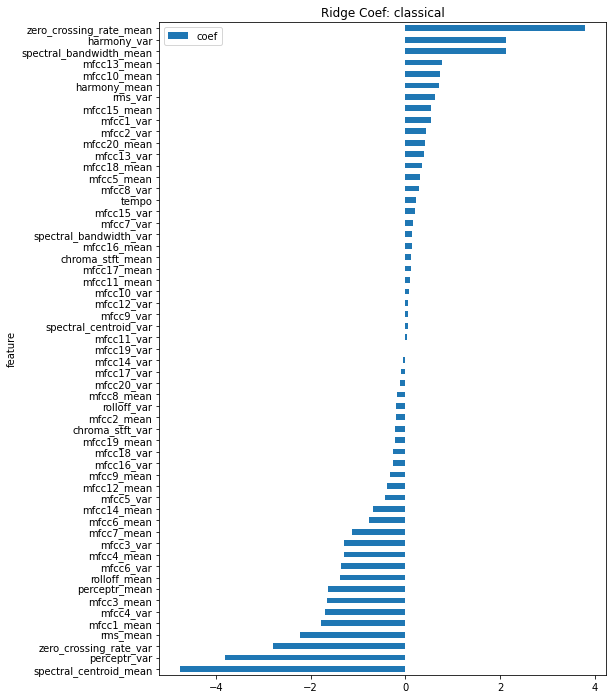

In [15]:
# model coefficients for classical class
pd.DataFrame(list(zip(X.columns, lr_ridge.coef_[1])), 
             columns=['feature', 'coef'])\
    .sort_values(by='coef') \
    .plot(kind='barh', x='feature', y='coef', figsize=(8, 12))
plt.title(f'Ridge Coef: {lr_ridge.classes_[1]}')
plt.show()

In [20]:
# create dataframe with model coefficients for each class
features_dict = {}

for i in range(10):
#     print(lr_ridge.classes_[i])
#     print(lr_ridge.coef_[i])
    features_dict[lr_ridge.classes_[i]] = lr_ridge.coef_[i]
    
df_features = pd.DataFrame(features_dict, index=X.columns)
df_features.head()

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock
chroma_stft_mean,-0.521110,0.122566,-0.756351,0.374769,2.117306,-0.900124,1.452521,-0.316433,0.377451,-0.238331
chroma_stft_var,0.914841,-0.218310,-0.052237,0.493996,0.724827,0.510086,0.462052,-0.069508,0.286305,0.527119
rms_mean,1.352206,-2.227737,-4.987723,-2.845065,0.344986,-1.323613,-2.795664,0.436954,-0.723856,-0.744056
rms_var,0.796102,0.631046,-1.535247,-0.208150,0.503640,0.600078,-2.651956,-0.045684,-0.703738,-0.923888
spectral_centroid_mean,-2.663507,-4.765937,-1.390100,-5.466852,-1.558503,4.283499,4.297432,-0.166283,1.765093,-0.760207


In [19]:
# fig, ax = plt.subplots(1,1, figsize=(12,14))
# pd.DataFrame(df_features.abs().sum(axis=1)/10, columns=['coef_abs_mean']).sort_values(by='coef_abs_mean').plot(kind='barh', ax=ax)
# plt.show()

In [21]:
# abs_mean column: absolute value, then take mean (divide by 10 genres)
df_features['abs_mean'] = df_features.abs().sum(axis=1)/10

# sort by abs_mean column
df_features = df_features.sort_values(by='abs_mean')
df_features

,blues,classical,country,disco,hiphop,jazz,metal,pop,reggae,rock,abs_mean
mfcc17_var,-0.101781,-0.086707,0.115835,-0.029913,0.168416,-0.114549,0.053360,0.010913,-0.036007,-0.053462,0.077094
mfcc12_var,-0.033425,0.054438,0.064833,0.226004,-0.072229,0.015604,-0.095972,0.064008,-0.028668,-0.226702,0.088188
mfcc14_var,-0.051309,-0.043929,0.030184,-0.112345,-0.037587,0.127312,0.299970,0.029677,0.097958,-0.070716,0.090099
mfcc19_var,-0.048037,-0.002743,-0.233947,-0.021801,-0.317138,0.225139,-0.095806,-0.020329,-0.016862,-0.122057,0.110386
tempo,0.126318,0.222717,-0.163876,-0.102386,-0.002492,-0.042493,0.138143,-0.017957,0.294583,-0.169253,0.128022
mfcc7_var,0.069596,0.164522,0.096370,-0.172814,0.055101,-0.205235,0.129837,-0.010648,0.408095,-0.035747,0.134796
mfcc16_var,0.109931,-0.271369,0.033282,-0.164967,-0.106900,0.136699,0.266552,0.147665,0.001643,-0.216624,0.145563
mfcc13_var,0.032719,0.385300,0.026709,0.037919,0.056342,-0.251684,0.349980,-0.000724,0.062268,-0.262465,0.146611
mfcc11_var,0.032859,0.028882,0.002167,0.118450,0.098523,-0.038813,-0.817309,-0.070662,0.204377,-0.157223,0.156926
mfcc8_var,0.139752,0.287293,-0.007217,-0.109832,0.104913,-0.049372,0.320189,-0.006578,0.217490,-0.370724,0.161336


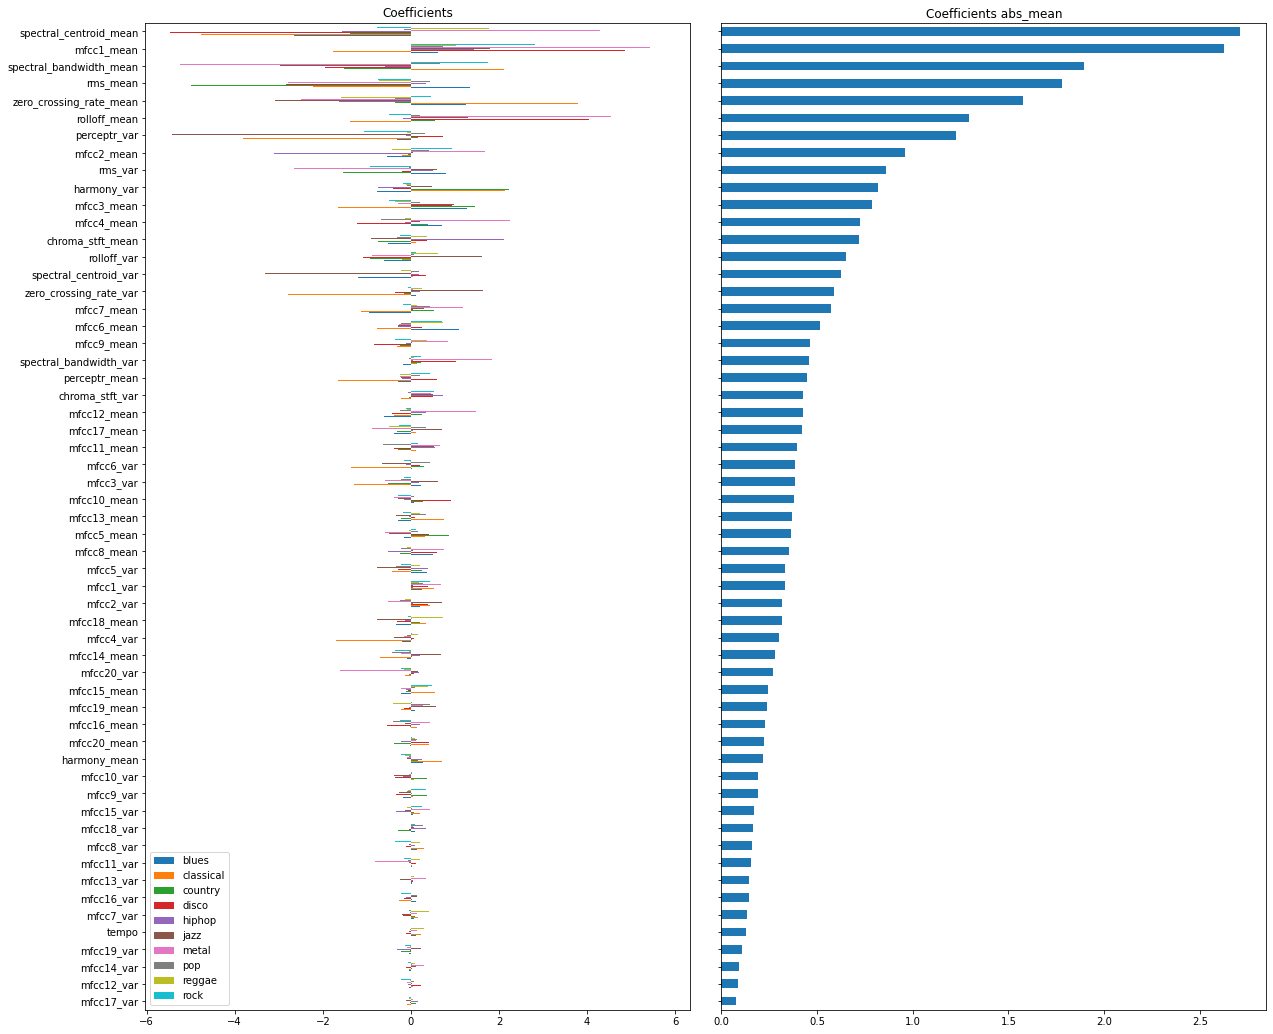

In [22]:
# horizontal bar ordered by coefficients abs_mean
fig, ax = plt.subplots(1,2, figsize=(16,14))
plt.tight_layout(pad=0)
df_features.iloc[:,:-1].plot(kind='barh', ax=ax[0], sharey=True)
df_features['abs_mean'].plot(kind='barh', ax=ax[1])
ax[0].set_title('Coefficients')
ax[1].set_title('Coefficients abs_mean')
plt.show()

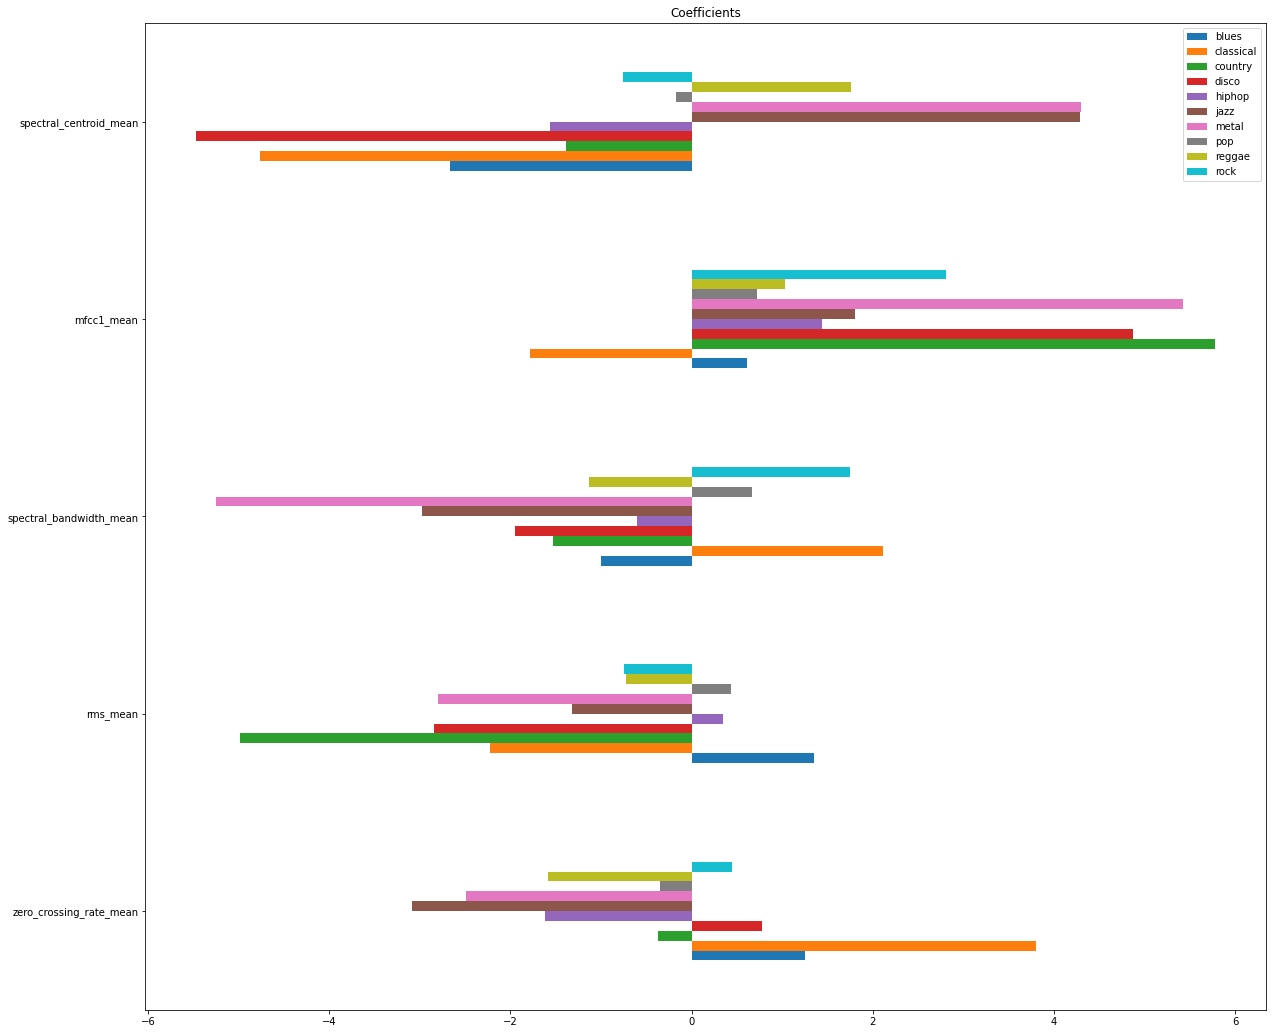

In [23]:
# top 5 coefficients, for each genre
fig, ax = plt.subplots(1,1, figsize=(16,14))
plt.tight_layout(pad=0)
df_features.iloc[-5:,:-1].plot(kind='barh', ax=ax)#[0], sharey=True)
ax.set_title('Coefficients')
plt.show()

# Predictions against actual class

In [27]:
# df_predictions = pd.DataFrame(lr_ridge.predict_proba(X_train), columns=lr_ridge.classes_)
# df_predictions.head()

In [29]:
# dataframe to compare model predictions against actual class
df_test_pred = X_test.copy()
df_test_pred['label'], df_test_pred['pred'] = y_test, lr_ridge.predict(X_test)

# column (True if prediction correct, False if incorrect)
df_test_pred['true_false'] = (df_test_pred.label == df_test_pred.pred)

df_test_pred.head()

,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,...,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label,pred,true_false
8122,0.006466,1.151329,-0.454924,-0.096288,-1.013039,-0.124978,-0.472557,1.576594,-0.823101,1.172676,...,0.685169,0.102035,0.433280,0.836686,1.698576,0.811672,0.855189,reggae,reggae,True
1323,-1.067772,0.241611,-1.850736,-0.762137,-1.830441,-0.939590,-1.743596,-0.996691,-1.988989,-1.049288,...,-0.941740,-0.516908,-0.830237,-0.674110,-0.465485,-0.016296,-0.759773,classical,classical,True
8394,-0.920652,0.402533,-1.376231,-0.589758,-0.413033,0.757470,-0.973097,0.008645,-0.633901,0.001642,...,-0.151185,0.337173,-0.056954,-0.279196,0.438655,-0.289404,0.486277,reggae,reggae,True
209,-0.972974,0.934979,-0.449765,0.554635,-0.860937,-0.368567,-0.603189,-0.580789,-0.836579,-0.425182,...,0.189558,0.383374,2.437225,0.846272,4.425751,0.644944,1.329055,blues,jazz,False
1999,-0.116581,-0.553790,1.785218,-0.628560,0.972471,0.606618,1.367279,-0.059064,1.223867,0.352396,...,-0.489234,-0.535900,-0.376840,-0.154197,0.496323,1.063757,0.258897,country,pop,False


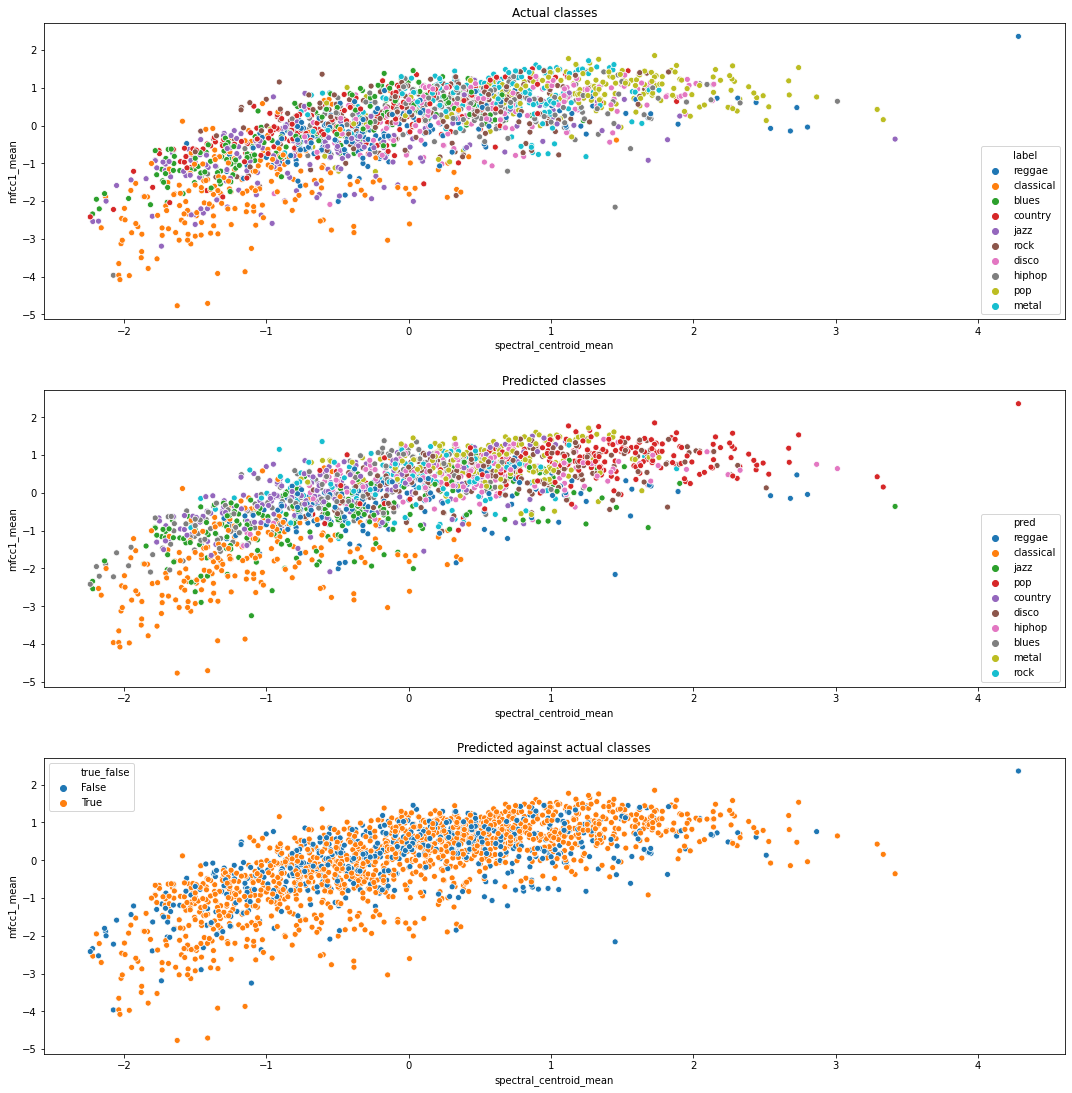

In [35]:
fig, ax = plt.subplots(3,1, figsize=(16,16))
plt.tight_layout(pad=5)

sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='label', ax=ax[0])
sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='pred', ax=ax[1])
sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='true_false', ax=ax[2])

ax[0].set_title('Actual classes')
ax[1].set_title('Predicted classes')
ax[2].set_title('Predicted against actual classes')


# plt.xscale('log')
# plt.yscale('log')
plt.show()

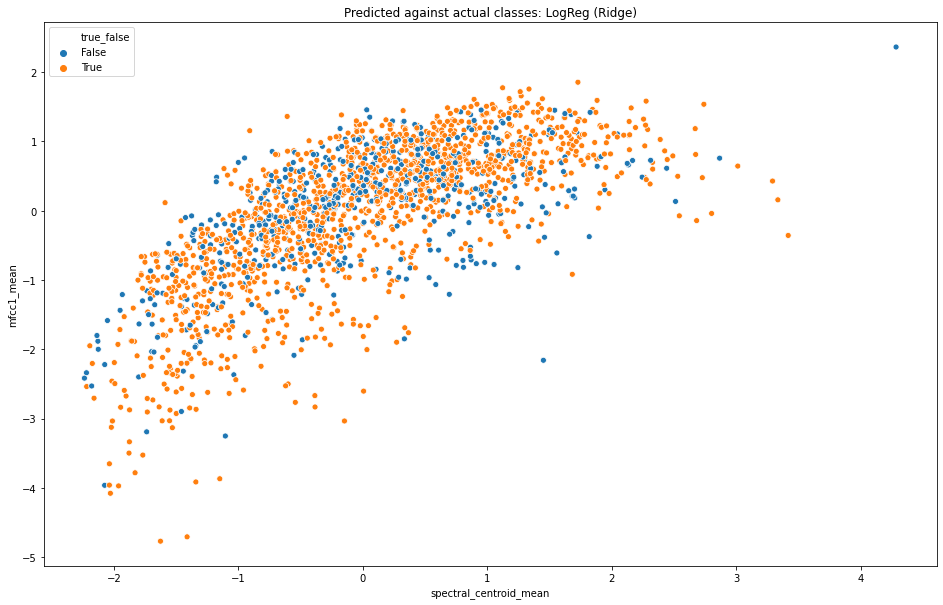

In [38]:
# Scatter to show model predictions against actual classes
fig, ax = plt.subplots(1,1, figsize=(16,10))
sns.scatterplot(x='spectral_centroid_mean', y='mfcc1_mean', data=df_test_pred, hue='true_false', ax=ax)
plt.title('Predicted against actual classes: LogReg (Ridge)')
plt.show()

In [27]:
# pickle logreg_cv
filename = 'log_cv.sav'
pickle.dump(model_cv, open(filename, 'wb'))

# pickle logreg_ridge
filename = 'log_ridge.sav'
pickle.dump(model_l2, open(filename, 'wb'))

# pickle logreg_cv
filename = 'log_lasso.sav'
pickle.dump(model_l1, open(filename, 'wb'))

In [29]:
# Plot precision and recall for all models

def plot_f1_lines(figsize=(8,6),fontsize=16):
    '''Create f1-score level lines to be added to the precison-recall plot'''

    fig, ax = plt.subplots(figsize=figsize)
    
    # add lines of constant F1 scores
    
    for const in np.linspace(0.2,0.9,8):
        x_vals = np.linspace(0.001, 0.999, 100)
        y_vals = 1./(2./const-1./x_vals)
        ax.plot(x_vals[y_vals > 0], y_vals[y_vals > 0],
                 color='lightblue', ls='--', alpha=0.9)
        ax.set_ylim([0, 1])
        ax.annotate('f1={0:0.1f}'.format(const),
                     xy=(x_vals[-10], y_vals[-2]+0.0), fontsize=fontsize)

    return fig, ax

LogReg CV


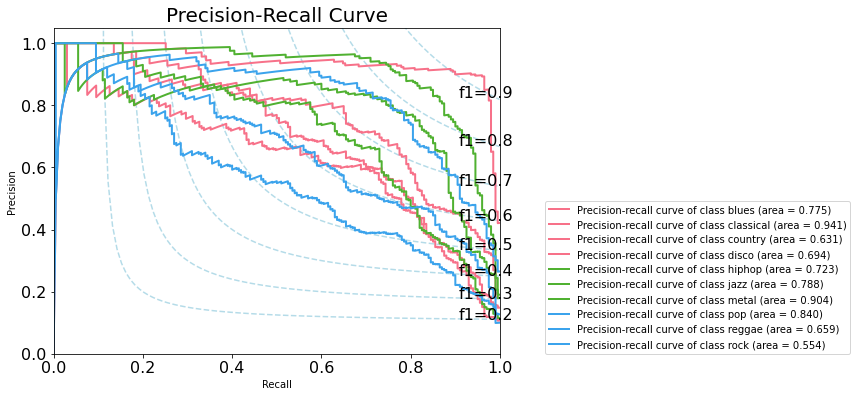

In [31]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_cv.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('LogReg CV')
plt.show()

LogReg Ridge


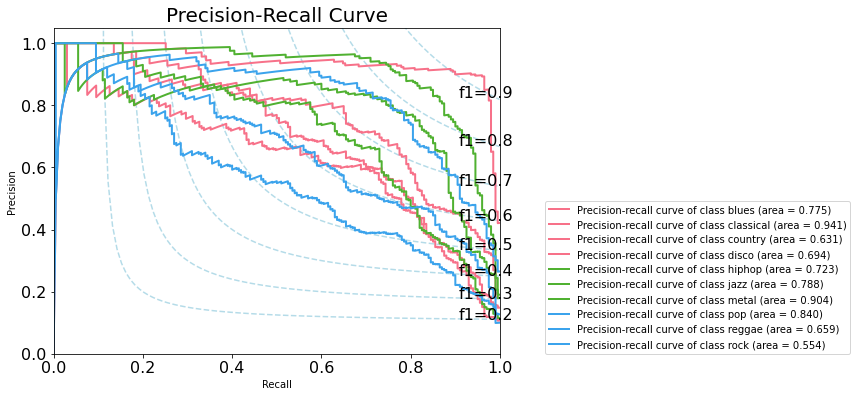

In [32]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_l2.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('LogReg Ridge')
plt.show()

LogReg Lasso


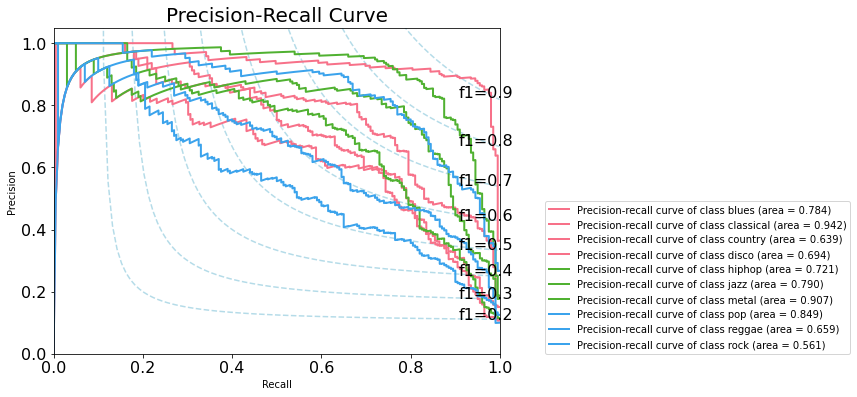

In [33]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, model_l1.predict_proba(X_test),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('LogReg Lasso')
plt.show()

LogReg CV


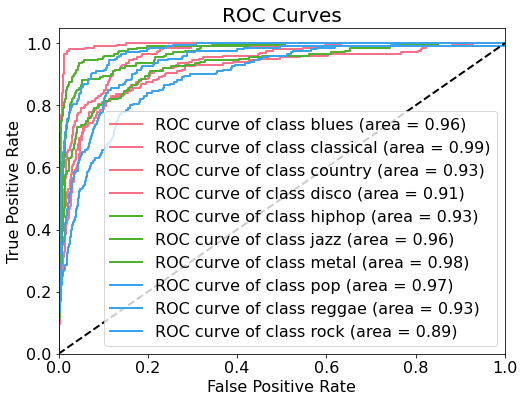

In [34]:
skplt.metrics.plot_roc(y_test, model_cv.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('LogReg CV')
plt.show()

LogReg Ridge


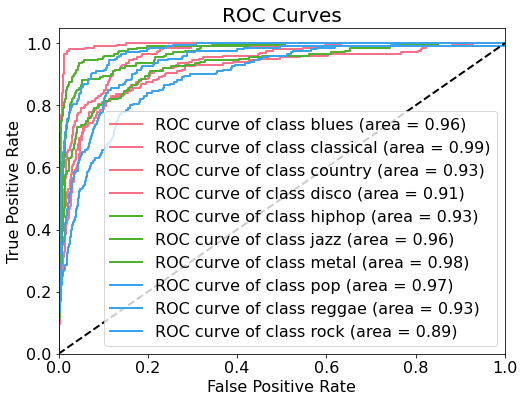

In [35]:
skplt.metrics.plot_roc(y_test, model_l2.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('LogReg Ridge')
plt.show()

LogReg Lasso


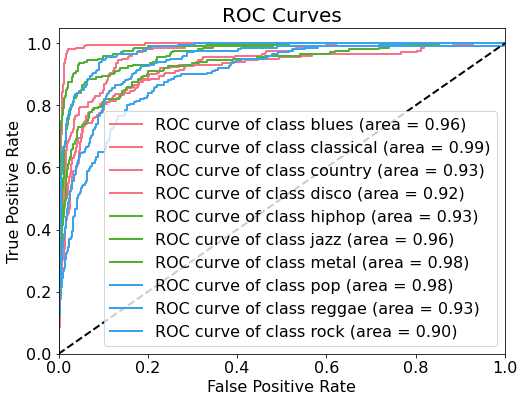

In [36]:
skplt.metrics.plot_roc(y_test, model_l1.predict_proba(X_test), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('LogReg Lasso')
plt.show()

## Accuracy against Cs
---

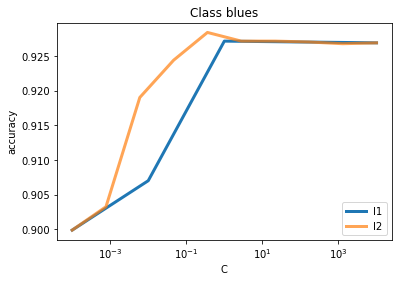

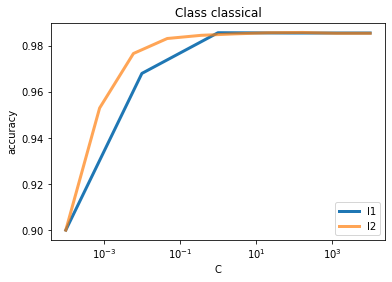

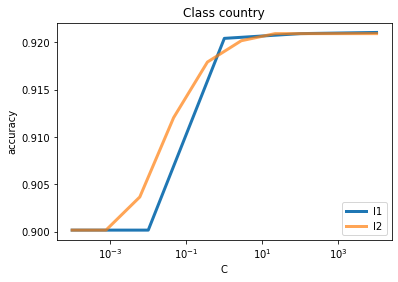

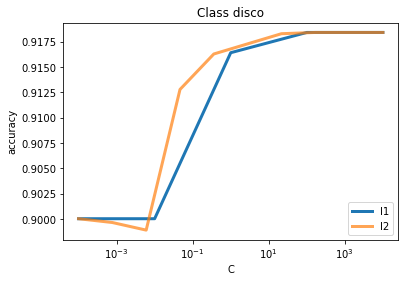

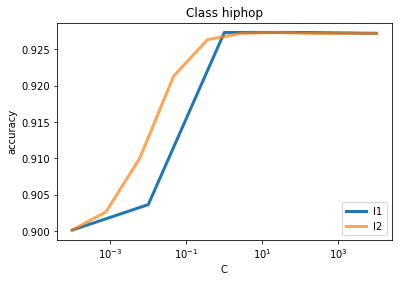

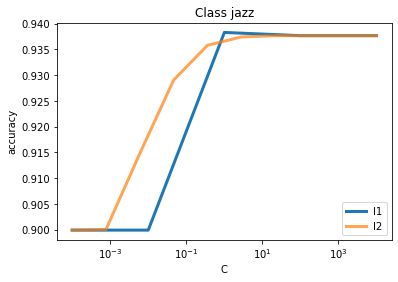

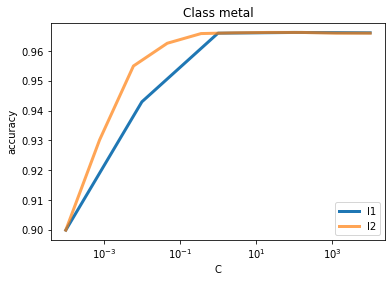

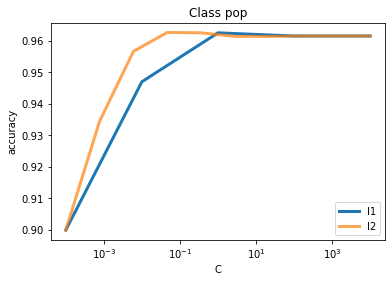

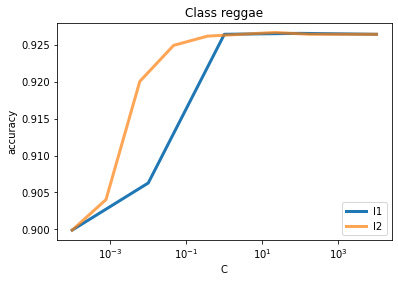

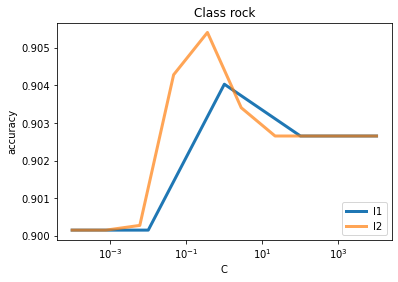

In [37]:
# Plot accuracy for each class against Cs

for i, cl in enumerate(model.classes_):
    plt.plot(model_l1.Cs_, list(model_l1.scores_.values())
             [i].mean(axis=0), lw=3, label='l1')
    plt.plot(model_l2.Cs_, list(model_l2.scores_.values())
             [i].mean(axis=0), lw=3, alpha=0.7, label='l2')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('Class {}'.format(cl))
    plt.show()

# LogReg (PCA features)
---

In [39]:
# PCA (n_components: 0.98)
n_components = 0.98
pca = PCA(n_components=n_components, random_state=1, svd_solver='full')
X_train_pc = pd.DataFrame(pca.fit_transform(X_train), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_train.index)

X_test_pc = pd.DataFrame(pca.transform(X_test), 
                         columns=[f'PC_{i+1}' for i in range(pca.n_components_)], index=X_test.index)

display(X_train_pc.head(3))
print(pca.explained_variance_ratio_.cumsum())

,PC_1,PC_2,PC_3,PC_4,PC_5,PC_6,PC_7,PC_8,PC_9,PC_10,...,PC_37,PC_38,PC_39,PC_40,PC_41,PC_42,PC_43,PC_44,PC_45,PC_46
1320,-5.293688,4.443151,-2.957230,-1.502260,1.299430,0.489461,-2.071782,-1.216299,0.051192,-1.539524,...,-0.447373,0.450370,0.022305,-0.644260,-0.643537,-0.027620,-0.942407,-0.561951,0.742484,0.397578
6402,-5.392128,-1.955827,1.586635,-0.751016,1.173739,1.085952,0.384503,1.599027,0.437988,0.155340,...,0.653101,-0.437954,-0.115268,-0.082793,-0.131461,-0.521167,0.179007,-0.282709,0.343379,0.196045
8371,3.845802,0.360897,2.259972,-3.776862,-3.246202,0.483324,2.781358,-0.556908,0.241289,-0.346836,...,0.627512,-0.568596,0.310562,0.729674,-0.667367,0.182800,-0.114664,-0.770347,-1.090391,-0.417285


[0.20145609 0.33625549 0.44005682 0.50615131 0.5495859  0.58661472
 0.61572067 0.64239527 0.66754207 0.6889598  0.70754409 0.72523707
 0.74229363 0.75717733 0.7707437  0.78242909 0.79347002 0.80424231
 0.81390884 0.82308936 0.83188758 0.84040319 0.8487457  0.85676566
 0.86462548 0.87214439 0.87954113 0.88679255 0.8937567  0.90062128
 0.907234   0.91369695 0.91991715 0.92595258 0.93193808 0.93768659
 0.94310807 0.9483235  0.95332003 0.95793797 0.96248721 0.96694968
 0.97120251 0.97532729 0.97931031 0.98297794]


## LogReg (PC)

LogReg (no regularisation)

Train score:	 0.7167167167167167
CV mean:	 0.6984475907384231
Test score:	 0.6891891891891891


array([[544,   2,  40,  18,  24,  49,  57,   0,  29,  37],
       [  2, 754,   8,   1,   0,  26,   1,   0,   0,   7],
       [ 70,   3, 493,  24,  12,  50,   6,  16,  25,  99],
       [ 23,   3,  33, 505,  62,   5,  17,  36,  31,  84],
       [ 31,   3,  22,  56, 495,   0,  25,  45, 109,  12],
       [ 30,  43,  31,   3,   1, 659,   0,   4,  11,  18],
       [ 22,   1,   5,  19,  11,   2, 697,   0,   6,  37],
       [  0,   4,  40,  25,  25,  11,   0, 664,  19,  12],
       [ 44,   1,  41,  35,  64,  11,   6,  35, 527,  36],
       [ 80,   6,  72,  92,  14,  34,  44,  23,  43, 390]])

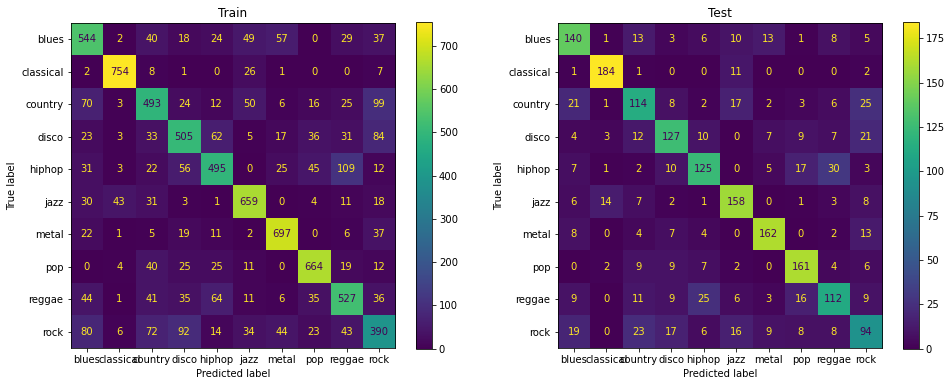

In [41]:
# fit model
log_pc = LogisticRegression(max_iter=10000)
log_pc.fit(X_train_pc, y_train)

train_score = log_pc.score(X_train_pc, y_train)
cv_mean = cross_val_score(log_pc, X_train_pc, y_train, cv=10).mean()
test_score = log_pc.score(X_test_pc, y_test)

print('LogReg (no regularisation)')
print()
print('Train score:\t', log_pc.score(X_train_pc, y_train))
print('CV mean:\t', cross_val_score(log_pc, X_train_pc, y_train, cv=10).mean())
print('Test score:\t', log_pc.score(X_test_pc, y_test))

# confusion matrix
pred_train = log_pc.predict(X_train_pc)
pred_test = log_pc.predict(X_test_pc)
conf_matrix = confusion_matrix(y_train, pred_train)
display(conf_matrix)

# plot confusion matrix
fig, ax = plt.subplots(1,2, figsize=(16,6))
plot_confusion_matrix(log_pc, X_train_pc, y_train, ax=ax[0])
plot_confusion_matrix(log_pc, X_test_pc, y_test, ax=ax[1])
ax[0].set_title('Train')
ax[1].set_title('Test')
plt.show()

In [42]:
class_report = classification_report(y_train, pred_train, digits=4)
print()
print('Classification report: train set')
print()
print(class_report)

class_report = classification_report(y_test, pred_test, digits=4)
print()
print('Classification report: test set')
print()
print(class_report)


Classification report: train set

              precision    recall  f1-score   support

       blues     0.6430    0.6800    0.6610       800
   classical     0.9195    0.9437    0.9314       799
     country     0.6280    0.6178    0.6229       798
       disco     0.6491    0.6320    0.6405       799
      hiphop     0.6992    0.6203    0.6574       798
        jazz     0.7780    0.8237    0.8002       800
       metal     0.8171    0.8712    0.8433       800
         pop     0.8068    0.8300    0.8182       800
      reggae     0.6587    0.6587    0.6587       800
        rock     0.5328    0.4887    0.5098       798

    accuracy                         0.7167      7992
   macro avg     0.7132    0.7166    0.7143      7992
weighted avg     0.7133    0.7167    0.7144      7992


Classification report: test set

              precision    recall  f1-score   support

       blues     0.6512    0.7000    0.6747       200
   classical     0.8932    0.9246    0.9086       199
     coun

In [43]:
log_cv_pc = LogisticRegressionCV(multi_class='ovr', max_iter=1000, cv=5, verbose=1)
log_cv_pc.fit(X_train_pc, y_train)

print('LogRegCV (PC features)')
print()
print('Train score:\t', log_cv_pc.score(X_train_pc, y_train))
print('CV mean:\t', cross_val_score(log_cv_pc, X_train_pc, y_train, cv=10).mean())
print('Test score:\t', log_cv_pc.score(X_test_pc, y_test))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


LogRegCV (PC features)

Train score:	 0.6943193193193193


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.6s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    4.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    5.7s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    6.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.1s finished
[Parallel(n_jobs=1)]: Us

CV mean:	 0.6788042866082604
Test score:	 0.6796796796796797


[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:    7.9s finished


In [44]:
log_ridge_pc = LogisticRegressionCV(penalty='l2', Cs=10, cv=5, multi_class='ovr', 
                                max_iter=1000, n_jobs=2, verbose=1)

log_ridge_pc.fit(X_train_pc, y_train)

print('LogReg Ridge (PC features)')
print()
print('Train score:\t', log_ridge_pc.score(X_train_pc, y_train))
print('CV mean:\t', cross_val_score(log_ridge_pc, X_train_pc, y_train, cv=10).mean())
print('Test score:\t', log_ridge_pc.score(X_test_pc, y_test))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.8s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    5.0s finished


LogReg Ridge (PC features)

Train score:	 0.6943193193193193


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  47 out of  50 | elapsed:    3.3s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    3.4s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  47 out of  50 | elapsed:    3.9s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  47 out of  50 | elapsed:    3.7s remaining:    0.2s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    3.8s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    4.3s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    4.0s finished
[Parallel(n_jobs=2)]: Using backend

CV mean:	 0.6788042866082604
Test score:	 0.6796796796796797


In [45]:
log_lasso_pc = LogisticRegressionCV(penalty='l1', Cs=5, cv=5, multi_class='ovr', solver='liblinear',  
                                max_iter=1000, n_jobs=2, verbose=1)

log_lasso_pc.fit(X_train_pc, y_train)

print('LogReg Lasso (PC features)')
print()
print('Train score:\t', log_lasso_pc.score(X_train_pc, y_train))
print('CV mean:\t', cross_val_score(log_lasso_pc, X_train_pc, y_train, cv=10).mean())
print('Test score:\t', log_lasso_pc.score(X_test_pc, y_test))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.9s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:   10.5s finished


LogReg Lasso (PC features)

Train score:	 0.6925675675675675


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    9.1s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.7s
[Parallel(n_jobs=2)]: Done  50 out of  50 | elapsed:    9.2s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done  50 out of  5

CV mean:	 0.677552565707134
Test score:	 0.6756756756756757


In [46]:
# pickle log_pc
filename = 'log_pc.sav'
pickle.dump(log_pc, open(filename, 'wb'))

# pickle log_pc
filename = 'log_cv_pc.sav'
pickle.dump(log_cv_pc, open(filename, 'wb'))

# pickle logreg_ridge
filename = 'log_ridge_pc.sav'
pickle.dump(log_ridge_pc, open(filename, 'wb'))

# pickle logreg_cv
filename = 'log_lasso_pc.sav'
pickle.dump(log_lasso_pc, open(filename, 'wb'))

log_pc


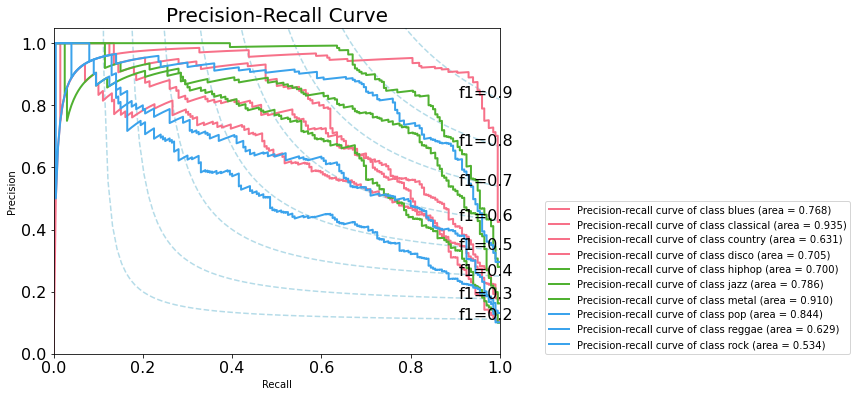

In [47]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, log_pc.predict_proba(X_test_pc),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('log_pc')
plt.show()

log_cv_pc


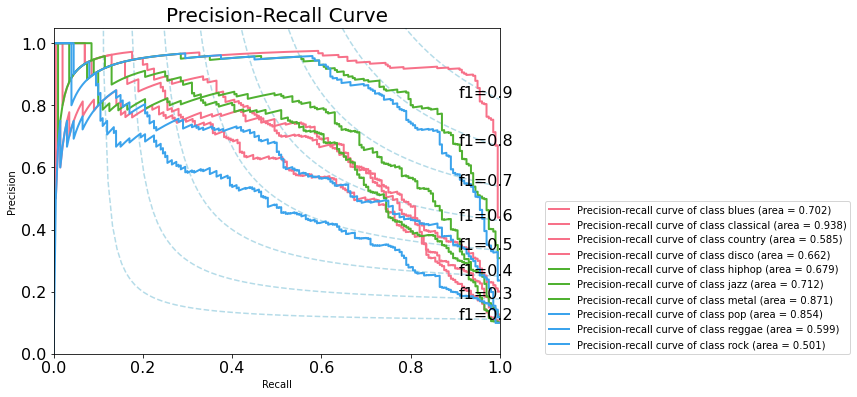

In [48]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, log_cv_pc.predict_proba(X_test_pc),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('log_cv_pc')
plt.show()

log_ridge_pc


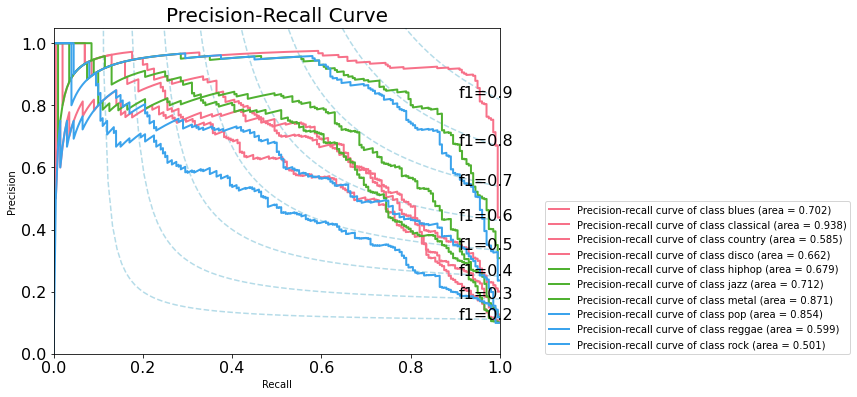

In [49]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, log_ridge_pc.predict_proba(X_test_pc),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('log_ridge_pc')
plt.show()

log_lasso_pc


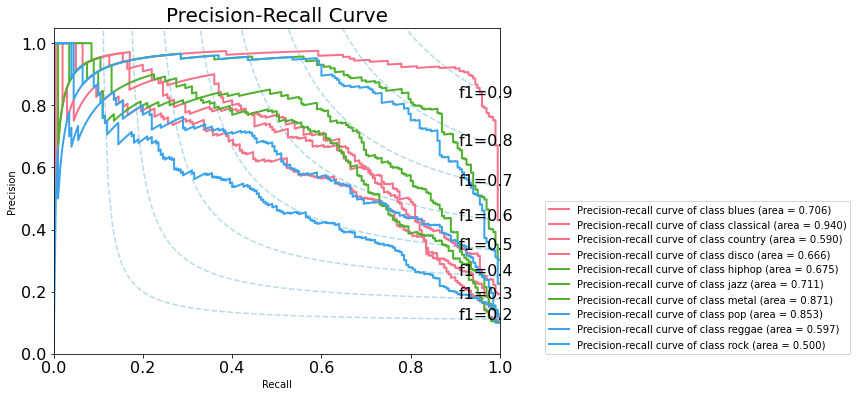

In [50]:
fig, ax = plot_f1_lines()
skplt.metrics.plot_precision_recall(y_test, log_lasso_pc.predict_proba(X_test_pc),
                                    plot_micro=False,
                                    title_fontsize=20, text_fontsize=16, cmap=cmap, ax=ax)
ax.legend(loc=[1.1, 0])
print('log_lasso_pc')
plt.show()

log_pc


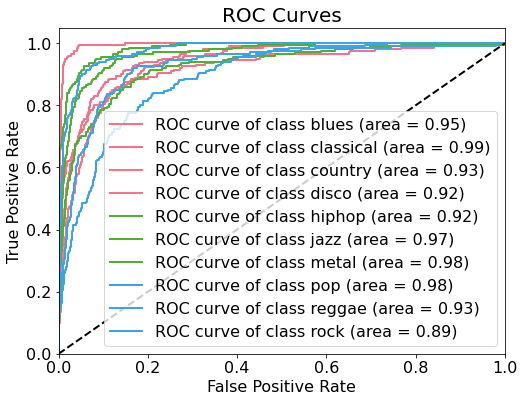

In [51]:
skplt.metrics.plot_roc(y_test, log_pc.predict_proba(X_test_pc), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('log_pc')
plt.show()

log_cv_pc


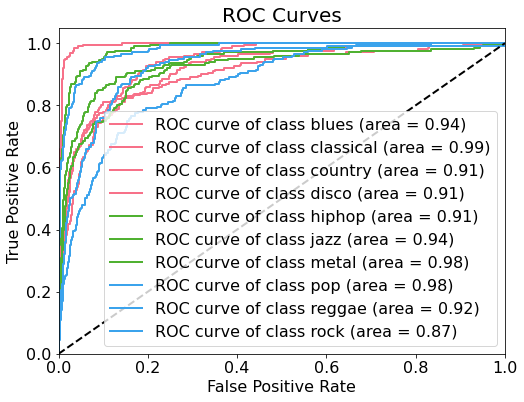

In [52]:
skplt.metrics.plot_roc(y_test, log_cv_pc.predict_proba(X_test_pc), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('log_cv_pc')
plt.show()

log_ridge_pc


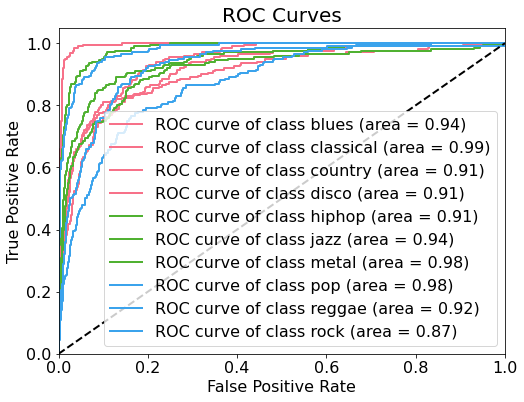

In [53]:
skplt.metrics.plot_roc(y_test, log_ridge_pc.predict_proba(X_test_pc), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('log_ridge_pc')
plt.show()

log_lasso_pc


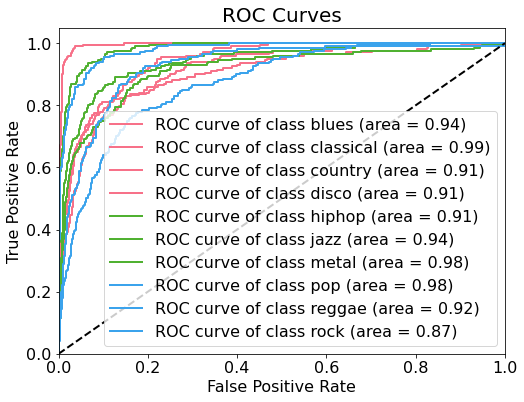

In [54]:
skplt.metrics.plot_roc(y_test, log_lasso_pc.predict_proba(X_test_pc), plot_micro=False, plot_macro=False,
                       title_fontsize=20, text_fontsize=16, figsize=(8, 6), cmap=cmap)
print('log_lasso_pc')
plt.show()

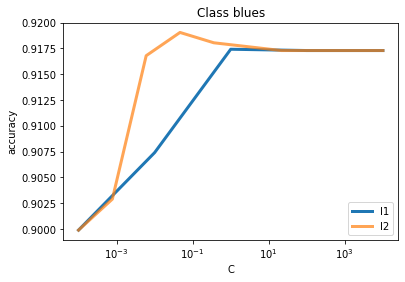

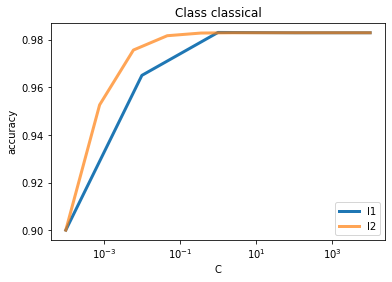

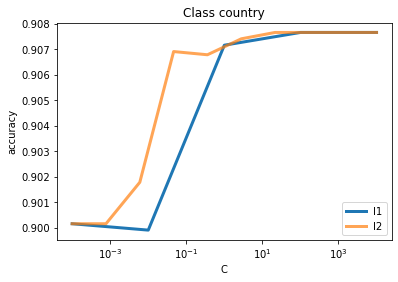

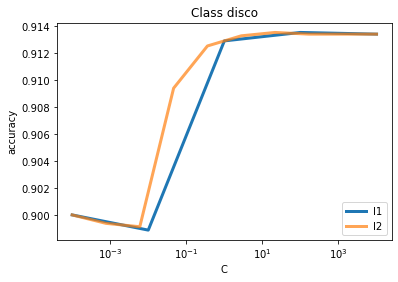

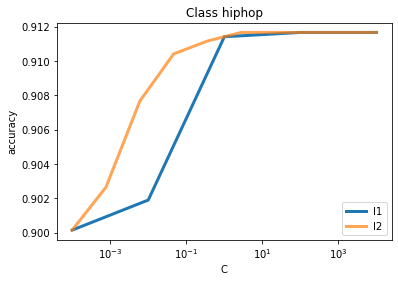

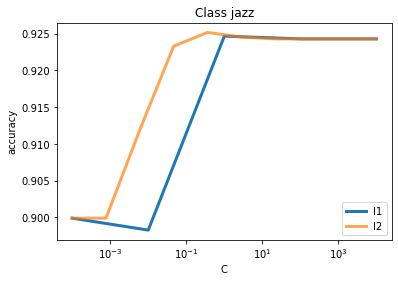

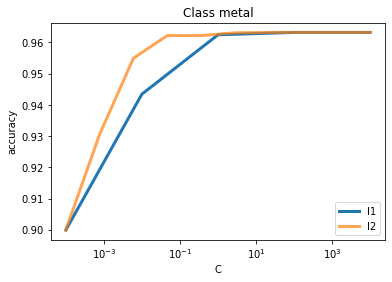

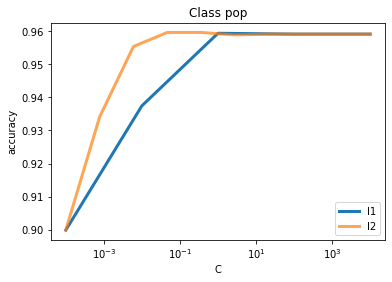

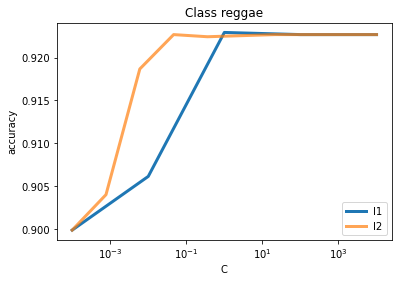

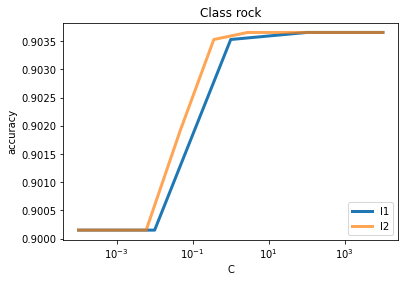

In [55]:
# Plot accuracy for each class against Cs

for i, cl in enumerate(model.classes_):
    plt.plot(log_lasso_pc.Cs_, list(log_lasso_pc.scores_.values())
             [i].mean(axis=0), lw=3, label='l1')
    plt.plot(log_ridge_pc.Cs_, list(log_ridge_pc.scores_.values())
             [i].mean(axis=0), lw=3, alpha=0.7, label='l2')
    plt.xscale('log')
    plt.xlabel('C')
    plt.ylabel('accuracy')
    plt.legend(loc='lower right')
    plt.title('Class {}'.format(cl))
    plt.show()